In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [32]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

#### Читаем оба временных ряда

In [47]:
df_nemo=pd.read_csv('./timelines_data/formed_timelines_2002/2002_spitz_nemo.csv', sep=';')
df_nemo['dates'] =  pd.to_datetime(df_nemo['dates'], format='%Y-%m-%d')
df_nemo['75.532663_17.902096_v']=df_nemo['75.532663_17.902096']-np.mean(df_nemo['75.532663_17.902096'])
df_nemo['76.006222_24.893752_v']=df_nemo['76.006222_24.893752']-np.mean(df_nemo['76.006222_24.893752'])
df_nemo['75.210923_11.252254_v']=df_nemo['75.210923_11.252254']-np.mean(df_nemo['75.210923_11.252254'])
df_rean=pd.read_csv('./timelines_data/formed_timelines_2002/2002_spitz_reanalysis.csv', sep=';')
df_rean['dates'] =  pd.to_datetime(df_rean['dates'], format='%Y-%m-%d')
df_rean['75.532663_17.902096_v']=df_rean['75.532663_17.902096']-np.mean(df_rean['75.532663_17.902096'])
df_rean['76.006222_24.893752_v']=df_rean['76.006222_24.893752']-np.mean(df_rean['76.006222_24.893752'])
df_rean['75.210923_11.252254_v']=df_rean['75.210923_11.252254']-np.mean(df_rean['75.210923_11.252254'])

#### Сглаживаем 14-дневную периодичность у NEMO

In [48]:
df_rean_list=[df_rean['75.210923_11.252254_v'], 
              df_rean['76.006222_24.893752_v'], 
              df_rean['75.532663_17.902096_v']]
df_nemo_list=[df_nemo['75.210923_11.252254_v'], 
              df_nemo['76.006222_24.893752_v'], 
              df_nemo['75.532663_17.902096_v']]

for i in range(len(df_rean_list)):
    windows_size=14
    gauss_sd=5
    window = signal.gaussian(windows_size, gauss_sd)

    output_gauss=signal.convolve(df_nemo_list[i], window/window.sum(), mode='same')
    f, Pxx_den = signal.welch(output_gauss, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    b_f, b_Pxx_den = signal.welch(df_nemo_list[i], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    df_nemo_list[i]=output_gauss
    
df_nemo

,75.532663_17.902096,76.006222_24.893752,75.210923_11.252254,dates,75.532663_17.902096_v,76.006222_24.893752_v,75.210923_11.252254_v
0,-0.866979,-0.890416,-0.945982,2002-01-01,0.003173,0.002300,0.015237
1,-0.907407,-0.904165,-0.967084,2002-01-02,-0.037255,-0.011450,-0.005865
2,-0.899823,-0.924889,-0.946681,2002-01-03,-0.029671,-0.032174,0.014538
3,-0.888992,-0.878961,-0.923555,2002-01-04,-0.018840,0.013754,0.037664
4,-0.879334,-0.882886,-0.898750,2002-01-05,-0.009182,0.009830,0.062469
...,...,...,...,...,...,...,...
360,-0.814204,-0.794452,-0.897989,2002-12-27,0.055948,0.098264,0.063230
361,-0.820932,-0.797816,-0.911585,2002-12-28,0.049220,0.094900,0.049634
362,-0.833964,-0.797317,-0.923432,2002-12-29,0.036189,0.095398,0.037787
363,-0.841198,-0.806413,-0.933277,2002-12-30,0.028954,0.086303,0.027943


#### Вычитаем остатки там, где они незначимы

In [49]:
for i in range(len(df_rean_list)):

    stl_n = STL(df_nemo_list[i], period=80)
    res_n = stl_n.fit()
    stl_r = STL(df_rean_list[i], period=80)
    res_r = stl_r.fit()
    df_nemo[df_rean_list[i].name[:-2]+'_no_res']=df_nemo_list[i]-res_n.resid
    df_rean[df_rean_list[i].name[:-2]+'_no_res']=df_rean_list[i]-res_r.resid


### Делаем гибридную модель (среднее значение NEMO и ARIMA)

In [50]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

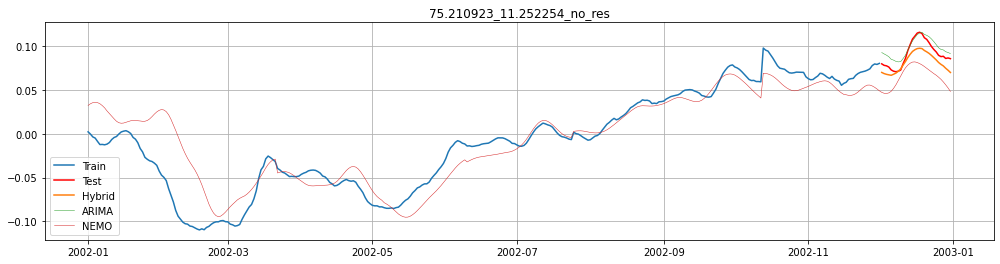

MSE =  0.0001222820571396964
MAE =  0.009855487740935781
MAPE =  10.387
R^2 =  0.41301586136384616


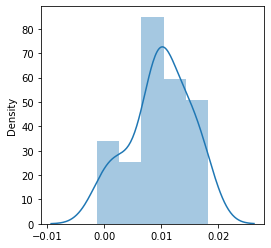

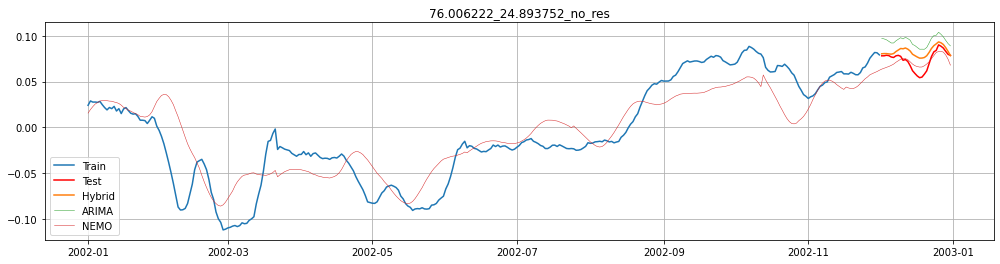

MSE =  0.00013089450071781145
MAE =  0.009236970486646186
MAPE =  14.075
R^2 =  -0.30789860057180274


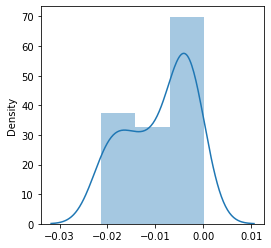

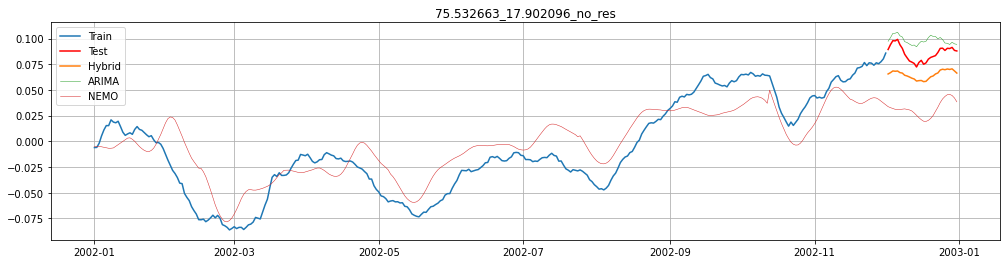

MSE =  0.0004464357561337178
MAE =  0.020684800283476117
MAPE =  23.935
R^2 =  -7.281434103953373


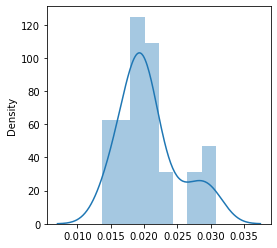

In [51]:
df_rean_list=[df_rean['75.210923_11.252254_no_res'], 
              df_rean['76.006222_24.893752_no_res'], 
              df_rean['75.532663_17.902096_no_res']]
df_nemo_list=[df_nemo['75.210923_11.252254_no_res'], 
              df_nemo['76.006222_24.893752_no_res'], 
              df_nemo['75.532663_17.902096_no_res']]

for i in range(len(df_rean_list)):
    
    test = df_rean_list[i][-30:]
    test.index = df_rean['dates'][-30:]
    data = df_rean_list[i][:-30]
    data.index = df_rean['dates'][:-30]
    
    nemo_pr=df_nemo_list[i][-30:]
    nemo_pr.index = df_nemo['dates'][-30:]

    stlf = STLForecast(data, ARIMA, period=80, model_kwargs={"order": (2, 1, 0)})
    model_res = stlf.fit()
    forecasts = model_res.forecast(30)
    
    hybrid_forecact=(nemo_pr+forecasts)/2
    
    plt.rcParams['figure.figsize'] = [17, 4]
    plt.plot(data, label='Train')
    plt.plot(test, c='r', label='Test')
    plt.plot(hybrid_forecact, label='Hybrid')
    plt.plot(forecasts, label='ARIMA', linewidth=0.5)
    plt.plot(df_nemo['dates'], df_nemo_list[i], label='NEMO', linewidth=0.5)
    
    plt.title(df_rean_list[i].name)
    plt.legend()
    plt.grid()
    plt.show()
    
    print("MSE = ", mean_squared_error(test, hybrid_forecact))
    print("MAE = ", mean_absolute_error(test, hybrid_forecact))
    print("MAPE = ", round(np.mean(np.abs(test-hybrid_forecact)/test)*100,3))
    print("R^2 = ", r2_score(test, hybrid_forecact))

    plt.rcParams['figure.figsize'] = [4, 4]
    sns.distplot(test-hybrid_forecact)
    plt.show()

### *В одном случае из трех наблюдается улучшение метрик*

___
ВАРИАНТЫ СЛЕДУЮЩИХ ЭКСПЕРИМЕНТОВ:
___
1) Протестировать на других участках временного ряда (сезонах - не только на декабре)

2) Набрать больше точек и повторить моделирование (может на каких-то участках работает лучше, на каких-то хуже)